In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

TIMEZONE = os.getenv("TIMEZONE")

# Load course paths from environment variables named COURSE_PATHS__<slug>=<path>
# Example .env entry:
#   COURSE_PATHS__python_course_slug=/home/user/courses/python_course_slug
# This script collects all such entries and builds a dict: {'python_course_slug': '/path', ...}
COURSE_PATHS = {
    key.split("__", 1)[1]: value
    for key, value in os.environ.items()
    if key.startswith("COURSE_PATHS__")
}

COURSE_PATHS

{'ztm_dsaiml': '/home/ezio4df/Videos/AI_ML/[FreeCourseSite.com] Udemy - Complete A.I. & Machine Learning, Data Science Bootcamp/',
 'ztm_pytorch': '/home/ezio4df/Videos/AI_ML/ZeroToMastery - PyTorch for Deep Learning Bootcamp Zero to Mastery 2025-4/'}

# CourseDurationTracker

In [2]:
import os
import pickle
from pathlib import Path
from typing import Dict, Tuple, Optional


class CourseDurationTracker:
    """
    Efficient Video-Based Learning Progress Tracker, this module provides a robust,
    cache-aware utility for tracking total and incremental durations across structured
    educational video content. Designed for self-paced learners or course platform
    developers, it supports hierarchical course layouts organized by lessons and videos,
    automatically parses numeric identifiers, computes cumulative progress, and persists
    results for fast subsequent access.

    The core abstraction assumes a strict but common filesystem layout:
    ```
    <course_root>/
    ├── <N><lesson_name>/                     # e.g., "1_intro", "12_advanced_topics"
    │   ├── <M><video_title>.mp4             # e.g., "1_welcome.mp4", "5_backprop.mp4"
    │   ├── <M+1><video_title>.mp4
    │   └── ...
    ├── <N+1><lesson_name>/
    │   └── ...
    └── ...
    ```

    Where:
    - `<N>` and `<M>` are **leading decimal integers** that determine sort order.
    - Non-numeric prefixes are ignored; only the first contiguous digit sequence is used.
    - All `.mp4` files in lesson folders are treated as course content.
    - Lesson and video ordering is **strictly numeric**, not lexicographic.

    The system uses `ffprobe` (from the FFmpeg suite) to extract accurate video durations.
    Results are cached via `pickle` to avoid costly re-scans. Cached data survives process
    restarts and is invalidated only if video files are added/removed (not modified).

    Primary use case: Given a course slug, lesson number, and video number, determine
    how much of the *entire course* has been completed **up to and including that video**.

    Example progression:
    - Course: "ml_fundamentals"
    - Current position: lesson 3, video 2
    → The tracker sums:
      - All videos in lessons 1 and 2
      - Videos 1 and 2 in lesson 3
    → Reports % of total course duration completed

    The class is thread-unsafe but safe for repeated invocation within a single thread.
    It makes no assumptions about video playback—only duration and structural position.

    Dependencies:
        - FFmpeg (specifically `ffprobe`) must be installed and available on PATH.
        - Python 3.7+

    Author: ezio4df@gmail.com (but codded by qwen ai)
    License: MIT
    """

    def __init__(self, cache_file: str = "course_cache.pkl"):
        self.cache_file = cache_file
        self.course_data = self._load_cache()
        self._cache_modified = False

    def _load_cache(self) -> Dict:
        """Load cached data from file."""
        if os.path.exists(self.cache_file):
            try:
                with open(self.cache_file, 'rb') as f:
                    return pickle.load(f)
            except (pickle.PickleError, EOFError):
                return {}
        return {}

    def _save_cache(self):
        """Save cached data to file."""
        if self._cache_modified:
            with open(self.cache_file, 'wb') as f:
                pickle.dump(self.course_data, f)
            self._cache_modified = False

    def _get_video_duration(self, video_path: str) -> float:
        """Get duration of a video file using ffprobe."""
        import subprocess
        try:
            result = subprocess.run([
                'ffprobe', '-v', 'quiet', '-show_entries',
                'format=duration', '-of', 'csv=p=0', video_path
            ], capture_output=True, text=True)
            duration = float(result.stdout.strip())
            return duration
        except Exception:
            # Fallback duration if ffprobe fails
            return 0.0

    def scan_courses(self, course_paths: Dict[str, str]):
        """
        Scan all courses and calculate durations.

        Args:
            course_paths: Dict mapping course slugs to folder paths
        """
        for course_slug, folder_path in course_paths.items():
            if course_slug not in self.course_data:
                self.course_data[course_slug] = {
                    'total_duration': 0.0,
                    'lessons': {}
                }

            course_dir = Path(folder_path)
            if not course_dir.exists():
                continue

            # Scan lessons in the course folder
            for lesson_dir in sorted(course_dir.iterdir()):
                if not lesson_dir.is_dir():
                    continue

                # Extract lesson number from directory name
                lesson_num = self._extract_number(lesson_dir.name)
                if lesson_num is None:
                    continue

                if lesson_num not in self.course_data[course_slug]['lessons']:
                    self.course_data[course_slug]['lessons'][lesson_num] = {
                        'total_duration': 0.0,
                        'videos': {}
                    }

                # Scan videos in the lesson folder
                for video_file in sorted(lesson_dir.glob("*.mp4")):
                    video_num = self._extract_number(video_file.stem)
                    if video_num is None:
                        continue

                    # Check if duration is already cached
                    if video_num not in self.course_data[course_slug]['lessons'][lesson_num]['videos']:
                        duration = self._get_video_duration(str(video_file))
                        self.course_data[course_slug]['lessons'][lesson_num]['videos'][video_num] = duration
                        self._cache_modified = True
                    else:
                        duration = self.course_data[course_slug]['lessons'][lesson_num]['videos'][video_num]

                    # Update totals
                    self.course_data[course_slug]['lessons'][lesson_num]['total_duration'] += duration
                    self.course_data[course_slug]['total_duration'] += duration

        self._save_cache()

    def _extract_number(self, s: str) -> Optional[int]:
        """Extract the leading number from a string."""
        import re
        match = re.match(r'^(\d+)', s)
        return int(match.group(1)) if match else None

    def get_course_stats(self) -> Dict[str, float]:
        """Get total duration for each course."""
        stats = {}
        for course_slug, data in self.course_data.items():
            stats[course_slug] = data['total_duration']
        return stats

    def get_total_duration(self) -> float:
        """Get total duration across all courses."""
        return sum(data['total_duration'] for data in self.course_data.values())

    def get_progress(self, course_slug: str, lesson_num: int, video_num: int) -> Dict[str, float]:
        """
        Get progress up to a specific video.

        Args:
            course_slug: Course identifier
            lesson_num: Lesson number
            video_num: Video number

        Returns:
            Dict with progress information
        """
        if course_slug not in self.course_data:
            return {'error': f'Course {course_slug} not found'}

        lessons = self.course_data[course_slug]['lessons']
        if lesson_num not in lessons:
            return {'error': f'Lesson {lesson_num} not found in course {course_slug}'}

        videos = lessons[lesson_num]['videos']
        if video_num not in videos:
            return {'error': f'Video {video_num} not found in lesson {lesson_num}'}

        # Calculate completed duration by summing all videos up to and including the specified one
        completed_duration = 0.0
        total_duration = self.course_data[course_slug]['total_duration']

        # Sort lessons by lesson number
        sorted_lessons = sorted(lessons.items())

        for curr_lesson_num, lesson_data in sorted_lessons:
            if curr_lesson_num < lesson_num:
                # Add duration of all videos in this lesson
                completed_duration += lesson_data['total_duration']
            elif curr_lesson_num == lesson_num:
                # Add duration of videos up to and including the specified video
                sorted_videos = sorted(lesson_data['videos'].items())
                for curr_video_num, video_duration in sorted_videos:
                    if curr_video_num <= video_num:
                        completed_duration += video_duration
                    else:
                        break
            else:
                # We've passed the target lesson, so stop
                break

        # Calculate percentage and remaining duration
        if total_duration > 0:
            progress = completed_duration / total_duration
        else:
            progress = 0.0

        remaining_duration = max(0.0, total_duration - completed_duration)

        return {
            'progress': progress,
            'remaining_duration': remaining_duration,
            'completed_duration': completed_duration,
            'total_duration': total_duration
        }

    def get_video_duration(self, course_slug: str, lesson_num: int, video_num: int) -> float:
        """Get duration of a specific video."""
        if (course_slug in self.course_data and
                lesson_num in self.course_data[course_slug]['lessons'] and
                video_num in self.course_data[course_slug]['lessons'][lesson_num]['videos']):
            return self.course_data[course_slug]['lessons'][lesson_num]['videos'][video_num]
        return 0.0

    def get_lesson_duration(self, course_slug: str, lesson_num: int) -> float:
        """Get total duration of a specific lesson."""
        if (course_slug in self.course_data and
                lesson_num in self.course_data[course_slug]['lessons']):
            return self.course_data[course_slug]['lessons'][lesson_num]['total_duration']
        return 0.0

    def get_all_videos(self, course_slug: str) -> Dict[Tuple[int, int], float]:
        """Get all videos in a course with their durations."""
        if course_slug not in self.course_data:
            return {}

        result = {}
        for lesson_num, lesson_data in self.course_data[course_slug]['lessons'].items():
            for video_num, duration in lesson_data['videos'].items():
                result[(lesson_num, video_num)] = duration
        return result

In [3]:
tracker = CourseDurationTracker()

# Scan courses (this will cache durations)
tracker.scan_courses(COURSE_PATHS)

In [4]:
# # Get total duration statistics
# stats = tracker.get_course_stats()
# print("Course Durations:", stats)
# print("Total Duration:", tracker.get_total_duration())
#
# # Get progress up to a specific video
# progress = tracker.get_progress('python_abc', 1, 2)
# print("Progress:", progress)
#
# # Get duration of a specific video
# duration = tracker.get_video_duration('python_abc', 1, 2)
# print(f"Video duration: {duration} seconds")

# Routine progress tracker

In [5]:
from datetime import datetime, timedelta, time, timezone
from typing import List, Dict, Optional
from zoneinfo import ZoneInfo


class RoutineProgressCalculator:
    def __init__(
            self,
            routine: List[List[str]],  # [session_name, start_time, end_time]
            start_datetime_str: str,  # ISO format datetime string
            end_datetime_str: str,  # ISO format datetime string
    ):
        """
        Initializes the RoutineProgressCalculator.

        Args:
            routine: A list of sessions, where each session is [session_name, start_time, end_time].
                     start_time and end_time are strings in "HH:MM" format.
            start_datetime_str: ISO format string for the start of the overall period.
            end_datetime_str: ISO format string for the end of the overall period.
        """
        self.routine = routine
        self.timezone = ZoneInfo(TIMEZONE or timezone.utc)

        # Parse input datetime strings to timezone-aware datetime objects
        self.start_dt = datetime.fromisoformat(start_datetime_str.replace("Z", "+00:00"))
        if self.start_dt.tzinfo is None:
            self.start_dt = self.start_dt.replace(tzinfo=self.timezone)
        else:
            self.start_dt = self.start_dt.astimezone(self.timezone)

        self.end_dt = datetime.fromisoformat(end_datetime_str.replace("Z", "+00:00"))
        if self.end_dt.tzinfo is None:
            self.end_dt = self.end_dt.replace(tzinfo=self.timezone)
        else:
            self.end_dt = self.end_dt.astimezone(self.timezone)

    def calculate_progress(self, current_datetime_str: Optional[str] = None) -> Dict[str, int]:
        """
        Calculates the progress of the routine schedule within the given time range.

        Args:
            current_datetime_str: ISO format string for the current time. Defaults to now if not provided.

        Returns:
            A dictionary containing:
                progress: Percentage of the routine completed (0-100).
                total_duration: Total duration of the routine within the period (in seconds, int).
                complete_duration: Duration of the routine completed by current_datetime (in seconds, int).
                remaining_duration: Duration of the routine remaining after current_datetime (in seconds, int).
        """
        if current_datetime_str is None:
            current_dt = datetime.now(self.timezone)
        else:
            current_dt = datetime.fromisoformat(current_datetime_str.replace("Z", "+00:00"))
            if current_dt.tzinfo is None:
                current_dt = current_dt.replace(tzinfo=self.timezone)
            else:
                current_dt = current_dt.astimezone(self.timezone)

        # Initialize durations in seconds
        total_duration_s = 0
        complete_duration_s = 0
        remaining_duration_s = 0

        # Determine the date range
        current_date = self.start_dt.date()
        end_date = self.end_dt.date()

        while current_date <= end_date:
            # Create the start and end datetime for the current date
            day_start_dt = datetime.combine(current_date, time(0, 0, 0)).replace(tzinfo=self.timezone)
            day_end_dt = datetime.combine(current_date, time(23, 59, 59)).replace(tzinfo=self.timezone)

            # Calculate the effective day range considering the overall start/end
            effective_day_start = max(day_start_dt, self.start_dt)
            effective_day_end = min(day_end_dt, self.end_dt)

            for session_name, start_time_str, end_time_str in self.routine:
                # Parse the session times for the current date
                h_start, m_start = map(int, start_time_str.split(':'))
                h_end, m_end = map(int, end_time_str.split(':'))

                # Create session datetime objects for the current date
                session_start_dt = datetime.combine(current_date, time(h_start, m_start)).replace(tzinfo=self.timezone)
                session_end_dt = datetime.combine(current_date, time(h_end, m_end)).replace(tzinfo=self.timezone)

                # Handle overnight sessions (e.g., 23:00 to 01:00 next day)
                if session_end_dt < session_start_dt:
                    session_end_dt += timedelta(days=1)

                # Calculate the overlap between the session and the effective day range
                overlap_start = max(session_start_dt, effective_day_start)
                overlap_end = min(session_end_dt, effective_day_end)

                # Calculate the overlap duration in seconds
                if overlap_end > overlap_start:
                    overlap_duration_s = int((overlap_end - overlap_start).total_seconds())
                    total_duration_s += overlap_duration_s

                    # Determine if the overlap period is before, during, or after current_datetime
                    if current_dt >= overlap_end:
                        # The entire overlap period is complete
                        complete_duration_s += overlap_duration_s
                    elif current_dt <= overlap_start:
                        # The entire overlap period is remaining
                        remaining_duration_s += overlap_duration_s
                    else:
                        # The overlap period is partially complete and partially remaining
                        complete_part_s = int((current_dt - overlap_start).total_seconds())
                        remaining_part_s = int((overlap_end - current_dt).total_seconds())
                        complete_duration_s += complete_part_s
                        remaining_duration_s += remaining_part_s

            current_date += timedelta(days=1)

        # Calculate progress percentage
        progress = 0.0
        if total_duration_s > 0:
            progress = complete_duration_s / total_duration_s

        return {
            "progress": progress,
            "total_duration": total_duration_s,
            "complete_duration": complete_duration_s,
            "remaining_duration": remaining_duration_s
        }

In [6]:
routine = RoutineProgressCalculator(
    routine=[
        ["M1", "06:00", "08:00"],
        ["M2", "09:00", "11:00"],
        ["M3", "12:00", "13:00"],
        ["D1", "15:00", "17:00"],
        ["D2", "18:00", "20:00"],
    ],
    start_datetime_str=os.getenv("START_DATETIME"),
    end_datetime_str=os.getenv("END_DATETIME"),
)

routine.calculate_progress(datetime.now().isoformat())

{'progress': 0.05022376543209876,
 'total_duration': 259200,
 'complete_duration': 13018,
 'remaining_duration': 246181}

# manage progress-over time

In [7]:
import pickle
import subprocess
import sys
import os
from datetime import datetime, timezone
import zoneinfo


class ProgressDataManager:
    def __init__(self, cache_file='course_progress.pkl'):
        self.cache_file = cache_file
        self.data = self._load_data()

    def _load_data(self):
        if os.path.exists(self.cache_file):
            with open(self.cache_file, 'rb') as f:
                return pickle.load(f)
        return []

    def _save_data(self):
        with open(self.cache_file, 'wb') as f:
            pickle.dump(self.data, f)

    def _prompt(self):
        default_value = ""
        if self.data:
            last_entry = self.data[-1]
            # last_entry format: (timestamp_iso_str, course_slug, lesson_num, video_num)
            default_value = f"{last_entry[1]}/"  # Use course_slug from last entry

        try:
            command = ['kdialog', '--inputbox', 'Enter position in format "string/int/int":', default_value]
            result = subprocess.run(
                command,
                capture_output=True, text=True, check=True
            )
            user_input = result.stdout.strip()
            return user_input if user_input else None
        except subprocess.CalledProcessError:
            print("Dialog was cancelled.")
            return None
        except FileNotFoundError:
            print("Error: kdialog not found.")
            sys.exit(1)

    def _parse_prompt_input(self, user_input):
        parts = user_input.split('/')
        if len(parts) != 3:
            raise ValueError("Format must be 'string/int/int'")
        return (parts[0], int(parts[1]), int(parts[2]))

    def ask(self):
        user_input = self._prompt()
        if user_input is not None:
            try:
                parsed_tuple = self._parse_prompt_input(user_input)  # (course_slug, lesson_num, video_num)
                if TIMEZONE:
                    tz = zoneinfo.ZoneInfo(TIMEZONE)
                    timestamp = datetime.now(tz)
                else:
                    timestamp = datetime.now(timezone.utc)

                entry = (timestamp, *parsed_tuple)  # (timestamp_obj, course_slug, lesson_num, video_num)

                # Insert while maintaining chronological order and lesson/video number order
                inserted = False
                for i, existing_entry in enumerate(self.data):
                    # existing_entry format: (timestamp_obj, course_slug, lesson_num, video_num)
                    existing_dt = existing_entry[0]
                    existing_lesson_num = existing_entry[2]
                    existing_video_num = existing_entry[3]

                    current_dt = entry[0]
                    current_lesson_num = entry[2]
                    current_video_num = entry[3]

                    # Compare based on timestamp
                    if current_dt > existing_dt:
                        # If timestamp is later, continue looking for the right spot
                        continue
                    elif current_dt < existing_dt:
                        # Found insertion point based on earlier timestamp
                        # Check lesson/video numbers against the existing entry at this time
                        if current_lesson_num < existing_lesson_num or \
                                (current_lesson_num == existing_lesson_num and current_video_num <= existing_video_num):
                            print(
                                f"Error: New entry's lesson/video ({current_lesson_num}/{current_video_num}) must be higher than entry at {existing_dt} ({existing_lesson_num}/{existing_video_num}).")
                            return
                        self.data.insert(i, entry)
                        inserted = True
                        break
                    elif current_dt == existing_dt:
                        # Same timestamp, check lesson/video numbers
                        if current_lesson_num < existing_lesson_num or \
                                (current_lesson_num == existing_lesson_num and current_video_num <= existing_video_num):
                            print(
                                f"Error: New entry's lesson/video ({current_lesson_num}/{current_video_num}) must be higher than entry at {current_dt} ({existing_lesson_num}/{existing_video_num}).")
                            return

                        # Find the correct position among entries with the same timestamp
                        j = i
                        while j < len(self.data) and self.data[j][0] == current_dt:
                            if current_lesson_num < self.data[j][2] or \
                                    (current_lesson_num == self.data[j][2] and current_video_num < self.data[j][3]):
                                self.data.insert(j, entry)
                                inserted = True
                                break
                            j += 1
                        if not inserted:
                            self.data.insert(j, entry)
                            inserted = True
                        break

                if not inserted:
                    # Append to the end if no earlier timestamp was found
                    self.data.append(entry)

                self._save_data()
            except ValueError as e:
                print(f"Error: {e}")
                return
            except IndexError:
                print("Error: Data entry format is inconsistent.")
                return

    def current_progress(self):
        """Returns the most recent entry for each unique course slug found in the data."""
        progress_map = {}
        for entry in self.data:
            # entry format: (timestamp_iso_str, course_slug, lesson_num, video_num)
            course_slug = entry[1]
            entry_dt = datetime.fromisoformat(entry[0])

            # Update the map if this entry is more recent for the course
            if course_slug not in progress_map or datetime.fromisoformat(progress_map[course_slug][0]) < entry_dt:
                progress_map[course_slug] = entry

        # Return just the values (the most recent entries)
        return list(progress_map.values())

In [8]:
# # Push sample data
# pdm = ProgressDataManager()
#
# """examples
#     python_abc/1/2
#     python_abc/2/8
#     pytorch_def/1/1
#     pytorch_def/2/3
#     pytorch_def/2/9
#     python_abc/3/18
# """
#
# pdm.data = [
#     (datetime(2025, 11, 1, 8, 3, 39, 376493, tzinfo=ZoneInfo("Asia/Dhaka")), 'python_abc', 1, 1),
#     (datetime(2025, 11, 1, 13, 3, 39, 376493, tzinfo=ZoneInfo("Asia/Dhaka")), 'python_abc', 2, 8),
#     (datetime(2025, 11, 1, 16, 3, 39, 376493, tzinfo=ZoneInfo("Asia/Dhaka")), 'pytorch_def', 1, 1),
#     (datetime(2025, 11, 2, 9, 3, 39, 376493, tzinfo=ZoneInfo("Asia/Dhaka")), 'pytorch_def', 2, 3),
#     (datetime(2025, 11, 2, 17, 3, 39, 376493, tzinfo=ZoneInfo("Asia/Dhaka")), 'pytorch_def', 2, 9),
#     (datetime(2025, 11, 2, 21, 13, 39, 376493, tzinfo=ZoneInfo("Asia/Dhaka")), 'python_abc', 3, 18),
# ]
# pdm._save_data()

In [9]:
pdm = ProgressDataManager()
pdm.ask()
pdm.data

Dialog was cancelled.


[(datetime.datetime(2025, 11, 3, 9, 5, 46, 40184, tzinfo=zoneinfo.ZoneInfo(key='Asia/Dhaka')),
  'ztm_dsaiml',
  13,
  213),
 (datetime.datetime(2025, 11, 3, 10, 24, 37, 29036, tzinfo=zoneinfo.ZoneInfo(key='Asia/Dhaka')),
  'ztm_dsaiml',
  14,
  215),
 (datetime.datetime(2025, 11, 3, 10, 26, 53, 115026, tzinfo=zoneinfo.ZoneInfo(key='Asia/Dhaka')),
  'ztm_pytorch',
  1,
  2)]

In [23]:
points = []
tmp_courses = {}  # {[course_slug]: progress_float}
for entry in pdm.data:
    created_at, *course_progress_position = entry

    # == x ==
    result = routine.calculate_progress(created_at.isoformat())
    x = round(result['progress'] * 1000)

    # == y ==
    y = tracker.get_progress(*course_progress_position)
    tmp_courses[course_progress_position[0]] = y['progress']
    y = round(sum(tmp_courses.values()) * 1000)

    points.append((x, y))

# scale y-axis to max 1000
points = [*map(lambda x: (x[0], x[1] / len(tmp_courses)), points)]

points

[(29, 210.5), (47, 217.5), (48, 218.0)]

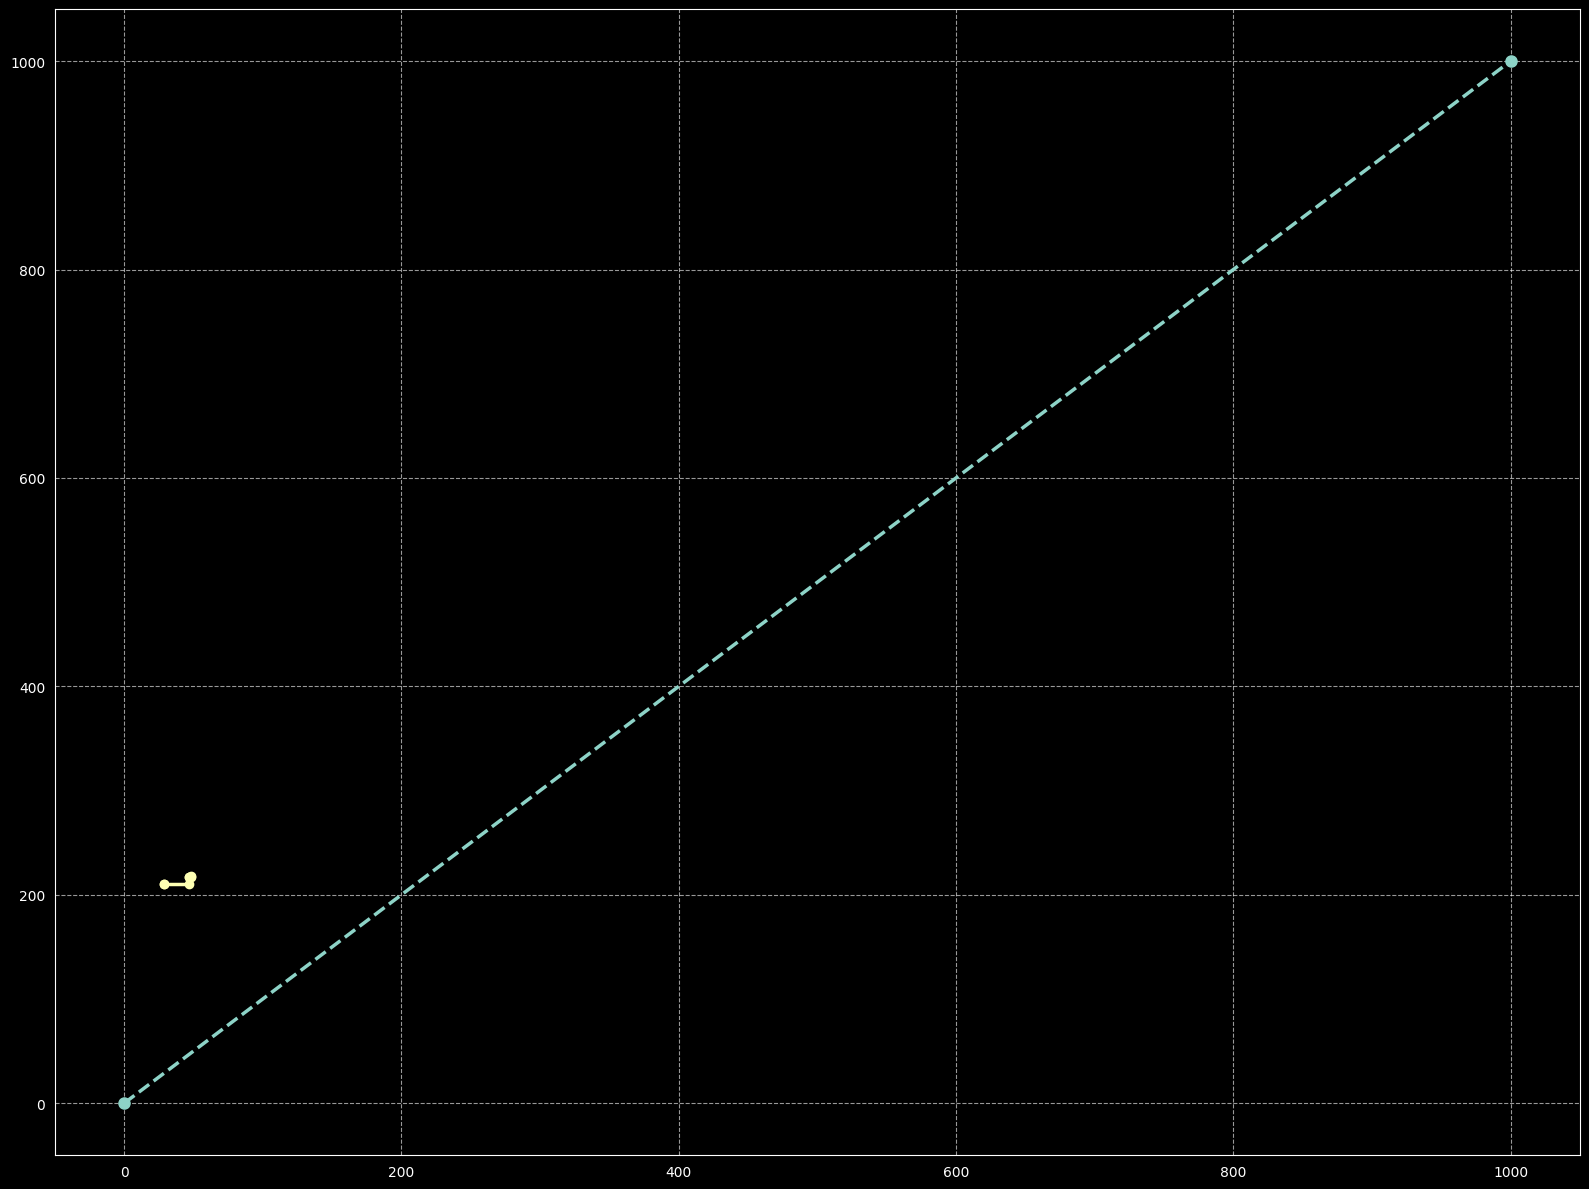

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import glob
import os

# == Set style for better-looking plots ==
plt.style.use('dark_background')
# sns.set_style("darkgrid")
plt.figure(figsize=(16, 12))

# Define the data points
x = [0, 1000]
y = [0, 1000]

# Create the plot
plt.plot(
    x, y,
    marker='o',
    linewidth=2.5,
    markersize=8,
    linestyle='--',
    # label='Line from (0,0) to (1000,1000)'
)

# Customize the plot
# plt.title('2D Line Graph: (0,0) to (1000,1000)', fontsize=14, fontweight='bold')
# plt.xlabel('X-axis', fontsize=12)
# plt.ylabel('Y-axis', fontsize=12)
# plt.legend()

# Add grid and adjust layout
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# == plot progress points ==
x_vals = [p[0] for p in points]
y_vals = [p[1] for p in points]

# Create stepped line by constructing intermediate points
x_stepped = []
y_stepped = []

for i in range(len(points)):
    if i == 0:
        x_stepped.extend([x_vals[i]])
        y_stepped.extend([y_vals[i]])
    else:
        # Horizontal step: same y as previous, x changes to current
        x_stepped.extend([x_vals[i - 1], x_vals[i]])
        y_stepped.extend([y_vals[i - 1], y_vals[i - 1]])
        # Vertical step: same x as current, y changes to current
        x_stepped.append(x_vals[i])
        y_stepped.append(y_vals[i])

# Plot the stepped line
plt.plot(x_stepped, y_stepped, marker='o', linewidth=2.5, markersize=6, label='Stepped Line')

# == Show the plot ==
# delete old and save new graph
for f in glob.glob("course_progress_*.png"):
    os.remove(f)
plot_img_filepath = f"course_progress_{random.randint(1111, 9999)}.png"
plt.savefig(plot_img_filepath, dpi=400)

plt.show()

In [25]:
from PIL import Image
import numpy as np

# Read the saved plot image
img = Image.open(plot_img_filepath)

# Create a black background image with target size
background = Image.new('RGB', (1920, 1080), color='black')

# Calculate scaling to fit the plot within the background while maintaining aspect ratio
img_ratio = img.width / img.height
target_ratio = 1920 / 1080

if img_ratio > target_ratio:
    # Fit to width
    new_width = 1920
    new_height = int(1920 / img_ratio)
else:
    # Fit to height
    new_height = 1080
    new_width = int(1080 * img_ratio)

# Resize the plot image
resized_img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

# Calculate position to center the plot on the background
x_offset = (1920 - new_width) // 2
y_offset = (1080 - new_height) // 2

# Paste the resized plot onto the black background
background.paste(resized_img, (x_offset, y_offset))

# Save the final image
background.save(plot_img_filepath)

In [26]:
subprocess.run(['plasma-apply-wallpaperimage', os.path.abspath(plot_img_filepath)])

Successfully set the wallpaper for all desktops to the image /home/ezio4df/projects/progress-slope/course_progress_4866.png


CompletedProcess(args=['plasma-apply-wallpaperimage', '/home/ezio4df/projects/progress-slope/course_progress_4866.png'], returncode=0)